In [2]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [3]:
df_volume = pd.read_csv('../data/2024/volume.csv', parse_dates=['time'])
df_high = pd.read_csv('../data/2024/high.csv', parse_dates=['time'])
df_low = pd.read_csv('../data/2024/low.csv', parse_dates=['time'])

# **1. Giả thuyết về mối quan hệ lượng - giá**

## _1.1. Biến động giá có tương quan dương với khối lượng giao dịch_

In [9]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Tính biến động giá (price volatility) như là (high - low)/low
volatility_df = (df_high.iloc[:, 1:] - df_low.iloc[:, 1:]) / df_low.iloc[:, 1:]

# Tính tương quan giữa biến động và khối lượng giao dịch cho từng cổ phiếu
correlations = []
symbols = df_volume.columns[1:]  # Lấy tên các cổ phiếu

for symbol in symbols:
    # Lọc dữ liệu không phải NaN
    valid_idx = ~(volatility_df[symbol].isna() | df_volume[symbol].isna())
    vol_data = volatility_df[symbol][valid_idx]
    volume_data = df_volume[symbol][valid_idx]
    
    if len(vol_data) > 5:  # Đảm bảo có đủ dữ liệu để tính tương quan
        corr, p_value = stats.pearsonr(vol_data, volume_data)
        correlations.append((symbol, corr, p_value))

# Hiển thị kết quả
correlations_df = pd.DataFrame(correlations, columns=['Symbol', 'Correlation', 'P-value'])
print("Tương quan giữa biến động giá và khối lượng giao dịch:")
print(correlations_df)

# Tính tổng hợp
avg_corr = correlations_df['Correlation'].mean()
significant_positive = sum((correlations_df['Correlation'] > 0) & (correlations_df['P-value'] < 0.05))
total_stocks = len(correlations_df)

print(f"\nTương quan trung bình: {avg_corr:.4f}")
print(f"Số cổ phiếu có tương quan dương có ý nghĩa thống kê: {significant_positive}/{total_stocks} ({significant_positive/total_stocks*100:.2f}%)")

# Kết luận
if avg_corr > 0 and significant_positive/total_stocks > 0.5:
    print("Kết luận: Có bằng chứng ủng hộ giả thuyết biến động giá có tương quan dương với khối lượng giao dịch.")
else:
    print("Kết luận: Không đủ bằng chứng ủng hộ giả thuyết biến động giá có tương quan dương với khối lượng giao dịch.")

Tương quan giữa biến động giá và khối lượng giao dịch:
   Symbol  Correlation       P-value
0     ACB     0.728871  1.087478e-42
1     BCM     0.688764  1.682904e-36
2     BID     0.421714  3.356984e-12
3     BVH     0.772477  8.134433e-51
4     CTG     0.737009  4.400644e-44
5     FPT     0.641383  2.264167e-30
6     GAS     0.657827  2.255840e-32
7     GVR     0.774547  3.018644e-51
8     HDB     0.455196  3.433528e-14
9     HPG     0.626996  1.020336e-28
10    LPB     0.719856  3.324458e-41
11    MBB     0.814914  1.108597e-60
12    MSN     0.639250  4.033952e-30
13    MWG     0.680508  2.383258e-35
14    PLX     0.729271  9.316761e-43
15    SAB     0.705560  5.770205e-39
16    SHB     0.828170  2.676787e-64
17    SSB     0.476381  1.442526e-15
18    SSI     0.567102  1.124248e-22
19    STB     0.544396  1.084531e-20
20    TCB     0.397169  7.105688e-11
21    TPB     0.603425  3.460121e-26
22    VCB     0.514730  2.579257e-18
23    VHM     0.562118  3.159306e-22
24    VIB     0.4860

## _1.2. Mức độ biến động của giá cổ phiếu tăng khi có khối lượng giao dịch cao bất thường_

In [12]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Tính biến động giá
volatility_df = (df_high.iloc[:, 1:] - df_low.iloc[:, 1:]) / df_low.iloc[:, 1:]
volatility_df['time'] = df_high['time']

# Phân tích cho từng cổ phiếu
results = []
symbols = df_volume.columns[1:]  # Lấy tên các cổ phiếu

for symbol in symbols:
    # Tạo DataFrame cho phân tích
    symbol_df = pd.DataFrame({
        'time': df_volume['time'],
        'volume': df_volume[symbol],
        'volatility': volatility_df[symbol]
    }).dropna()
    
    if len(symbol_df) > 20:  # Đảm bảo có đủ dữ liệu
        # Tính rolling mean của khối lượng giao dịch (window 20 ngày)
        symbol_df['volume_rolling_mean'] = symbol_df['volume'].rolling(window=20).mean()
        
        # Xác định ngày có khối lượng giao dịch cao bất thường (>200% so với trung bình 20 ngày)
        symbol_df['high_volume'] = symbol_df['volume'] > 2.0 * symbol_df['volume_rolling_mean']
        
        # Loại bỏ các hàng có NaN (do rolling window)
        filtered_df = symbol_df.dropna()
        
        if filtered_df['high_volume'].sum() > 5 and (~filtered_df['high_volume']).sum() > 5:
            # Chia thành 2 nhóm: ngày có khối lượng cao và ngày bình thường
            high_vol_days = filtered_df[filtered_df['high_volume']]['volatility']
            normal_days = filtered_df[~filtered_df['high_volume']]['volatility']
            
            # So sánh biến động giữa 2 nhóm
            high_vol_mean = high_vol_days.mean()
            normal_mean = normal_days.mean()
            
            # T-test
            t_stat, p_value = stats.ttest_ind(high_vol_days, normal_days, equal_var=False)
            
            results.append((symbol, high_vol_mean, normal_mean, len(high_vol_days), len(normal_days), t_stat, p_value))

# Hiển thị kết quả
if results:
    results_df = pd.DataFrame(results, columns=[
        'Symbol', 'High Volume Volatility', 'Normal Volatility', 
        'High Volume Days', 'Normal Days', 't-statistic', 'p-value'
    ])
    
    print("So sánh biến động giá giữa ngày có khối lượng giao dịch cao bất thường và ngày bình thường:")
    print(results_df)
    
    # Tổng hợp kết quả
    higher_vol = sum(results_df['High Volume Volatility'] > results_df['Normal Volatility'])
    significant_higher = sum((results_df['High Volume Volatility'] > results_df['Normal Volatility']) & 
                            (results_df['p-value'] < 0.05))
    total_tested = len(results_df)
    
    print(f"\nSố cổ phiếu có biến động cao hơn trong ngày giao dịch khối lượng lớn: {higher_vol}/{total_tested} ({higher_vol/total_tested*100:.2f}%)")
    print(f"Số cổ phiếu có biến động cao hơn đáng kể: {significant_higher}/{total_tested} ({significant_higher/total_tested*100:.2f}%)")
    
    # Kết luận
    if significant_higher/total_tested > 0.5:
        print("Kết luận: Có bằng chứng ủng hộ giả thuyết biến động giá cổ phiếu tăng khi có khối lượng giao dịch cao bất thường.")
    else:
        print("Kết luận: Không đủ bằng chứng ủng hộ giả thuyết biến động giá cổ phiếu tăng khi có khối lượng giao dịch cao bất thường.")
else:
    print("Không đủ dữ liệu để kiểm định giả thuyết.")

So sánh biến động giá giữa ngày có khối lượng giao dịch cao bất thường và ngày bình thường:
   Symbol  High Volume Volatility  Normal Volatility  High Volume Days  \
0     ACB                0.037207           0.015055                 9   
1     BCM                0.043160           0.023926                11   
2     BID                0.040346           0.022023                10   
3     BVH                0.041441           0.019926                19   
4     CTG                0.049745           0.021657                11   
5     FPT                0.038933           0.019097                12   
6     GAS                0.033029           0.014322                10   
7     GVR                0.066597           0.031820                10   
8     HPG                0.033941           0.018207                 8   
9     LPB                0.045548           0.024733                18   
10    MBB                0.039899           0.019273                15   
11    MSN           

## _1.3. Mối quan hệ giữa volume giao dịch và giá cổ phiếu có sự thay đổi theo mùa (quý, tháng)_

In [15]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Tính biến động giá
price_change = (df_high.iloc[:, 1:] - df_low.iloc[:, 1:]) / df_low.iloc[:, 1:]

# Tạo DataFrame với dữ liệu thời gian
correlation_df = pd.DataFrame({
    'time': df_volume['time'],
    'month': df_volume['time'].dt.month,
    'quarter': df_volume['time'].dt.quarter
})

# Phân tích theo tháng
monthly_correlations = {}
for month in range(1, 13):
    month_corrs = []
    for symbol in df_volume.columns[1:]:
        month_idx = correlation_df['month'] == month
        if month_idx.sum() > 5:  # Đảm bảo đủ dữ liệu
            vol_data = df_volume[symbol][month_idx].dropna()
            price_data = price_change[symbol][month_idx].dropna()
            
            # Lấy các chỉ số hợp lệ cho cả hai
            valid_idx = vol_data.index.intersection(price_data.index)
            if len(valid_idx) > 5:
                corr, _ = stats.pearsonr(vol_data.loc[valid_idx], price_data.loc[valid_idx])
                month_corrs.append(corr)
    
    if month_corrs:
        monthly_correlations[month] = month_corrs

# Phân tích theo quý
quarterly_correlations = {}
for quarter in range(1, 5):
    quarter_corrs = []
    for symbol in df_volume.columns[1:]:
        quarter_idx = correlation_df['quarter'] == quarter
        if quarter_idx.sum() > 10:  # Đảm bảo đủ dữ liệu
            vol_data = df_volume[symbol][quarter_idx].dropna()
            price_data = price_change[symbol][quarter_idx].dropna()
            
            # Lấy các chỉ số hợp lệ cho cả hai
            valid_idx = vol_data.index.intersection(price_data.index)
            if len(valid_idx) > 10:
                corr, _ = stats.pearsonr(vol_data.loc[valid_idx], price_data.loc[valid_idx])
                quarter_corrs.append(corr)
    
    if quarter_corrs:
        quarterly_correlations[quarter] = quarter_corrs

# Kiểm định ANOVA để xem tương quan có khác nhau theo mùa không
monthly_anova_data = [corrs for corrs in monthly_correlations.values() if len(corrs) > 5]
quarterly_anova_data = [corrs for corrs in quarterly_correlations.values() if len(corrs) > 5]

# Kết quả phân tích theo tháng
print("Tương quan trung bình giữa volume và biến động giá theo tháng:")
for month, corrs in monthly_correlations.items():
    if corrs:
        avg_corr = np.mean(corrs)
        pos_count = sum(c > 0 for c in corrs)
        print(f"Tháng {month}: {avg_corr:.4f} (dương: {pos_count}/{len(corrs)} = {pos_count/len(corrs)*100:.1f}%)")

# Kết quả phân tích theo quý
print("\nTương quan trung bình giữa volume và biến động giá theo quý:")
for quarter, corrs in quarterly_correlations.items():
    if corrs:
        avg_corr = np.mean(corrs)
        pos_count = sum(c > 0 for c in corrs)
        print(f"Quý {quarter}: {avg_corr:.4f} (dương: {pos_count}/{len(corrs)} = {pos_count/len(corrs)*100:.1f}%)")

# Kiểm định sự khác biệt
if len(monthly_anova_data) > 1:
    f_stat, p_value = stats.f_oneway(*monthly_anova_data)
    print(f"\nKiểm định ANOVA cho tương quan theo tháng: F={f_stat:.4f}, p-value={p_value:.4f}")
    if p_value < 0.05:
        print("Kết luận: Có bằng chứng cho thấy tương quan giữa volume và biến động giá thay đổi theo tháng.")
    else:
        print("Kết luận: Không đủ bằng chứng cho thấy tương quan thay đổi theo tháng.")

if len(quarterly_anova_data) > 1:
    f_stat, p_value = stats.f_oneway(*quarterly_anova_data)
    print(f"Kiểm định ANOVA cho tương quan theo quý: F={f_stat:.4f}, p-value={p_value:.4f}")
    if p_value < 0.05:
        print("Kết luận: Có bằng chứng cho thấy tương quan giữa volume và biến động giá thay đổi theo quý.")
    else:
        print("Kết luận: Không đủ bằng chứng cho thấy tương quan thay đổi theo quý.")

Tương quan trung bình giữa volume và biến động giá theo tháng:
Tháng 1: 0.6541 (dương: 29/30 = 96.7%)
Tháng 2: 0.7673 (dương: 30/30 = 100.0%)
Tháng 3: 0.6644 (dương: 30/30 = 100.0%)
Tháng 4: 0.5859 (dương: 30/30 = 100.0%)
Tháng 5: 0.6677 (dương: 30/30 = 100.0%)
Tháng 6: 0.6355 (dương: 30/30 = 100.0%)
Tháng 7: 0.6624 (dương: 30/30 = 100.0%)
Tháng 8: 0.6666 (dương: 29/30 = 96.7%)
Tháng 9: 0.5511 (dương: 29/30 = 96.7%)
Tháng 10: 0.6972 (dương: 30/30 = 100.0%)
Tháng 11: 0.5933 (dương: 30/30 = 100.0%)
Tháng 12: 0.6736 (dương: 30/30 = 100.0%)

Tương quan trung bình giữa volume và biến động giá theo quý:
Quý 1: 0.7020 (dương: 29/30 = 96.7%)
Quý 2: 0.6127 (dương: 30/30 = 100.0%)
Quý 3: 0.6211 (dương: 29/30 = 96.7%)
Quý 4: 0.6567 (dương: 30/30 = 100.0%)

Kiểm định ANOVA cho tương quan theo tháng: F=2.6822, p-value=0.0025
Kết luận: Có bằng chứng cho thấy tương quan giữa volume và biến động giá thay đổi theo tháng.
Kiểm định ANOVA cho tương quan theo quý: F=1.8380, p-value=0.1441
Kết luận: Không 

## _1.4. Giá cổ phiếu có xu hướng giảm trong những ngày có lượng giao dịch cao_

In [22]:
import pandas as pd
import numpy as np
from scipy import stats

# Tính giá trung bình cho mỗi ngày
price_df = (df_high.iloc[:, 1:] + df_low.iloc[:, 1:]) / 2
price_df['time'] = df_high['time']

# Tính giá thay đổi hàng ngày (% thay đổi so với ngày trước)
daily_returns = price_df.iloc[:, :-1].pct_change()
daily_returns['time'] = price_df['time']

# Xác định ngày có volume cao (top 20%)
volume_percentile = 80
high_volume_days = {}

for symbol in df_volume.columns[1:]:
    # Chỉ xét các ngày có dữ liệu khối lượng
    valid_volume = df_volume[symbol].dropna()
    if len(valid_volume) > 20:
        threshold = np.percentile(valid_volume, volume_percentile)
        high_volume_days[symbol] = df_volume['time'][df_volume[symbol] > threshold].tolist()

# Kiểm tra tương quan giữa khối lượng cao và sự thay đổi giá
negative_returns = 0
significant_negative = 0
total_analyzed = 0
avg_returns = []

for symbol in df_volume.columns[1:]:
    if symbol in high_volume_days and len(high_volume_days[symbol]) > 5:
        total_analyzed += 1
        
        # Lấy giá trị thay đổi vào ngày có khối lượng cao
        high_vol_returns = []
        for date in high_volume_days[symbol]:
            if date in daily_returns['time'].values:
                ret = daily_returns.loc[daily_returns['time'] == date, symbol].values[0]
                if not pd.isna(ret):
                    high_vol_returns.append(ret)
        
        if high_vol_returns:
            avg_return = np.mean(high_vol_returns) * 100  # Chuyển sang phần trăm
            avg_returns.append(avg_return)
            
            # Kiểm định thống kê
            t_stat, p_value = stats.ttest_1samp(high_vol_returns, 0)
            
            if avg_return < 0:
                negative_returns += 1
                if p_value < 0.05 and t_stat < 0:
                    significant_negative += 1

# Kết quả tổng hợp
if avg_returns:
    overall_avg_return = np.mean(avg_returns)
    print(f"Thay đổi giá trung bình trong ngày có khối lượng giao dịch cao: {overall_avg_return:.2f}%")
    print(f"Số cổ phiếu có xu hướng giảm giá: {negative_returns}/{total_analyzed} ({negative_returns/total_analyzed*100:.1f}%)")
    print(f"Số cổ phiếu có xu hướng giảm đáng kể (p < 0.05): {significant_negative}/{total_analyzed} ({significant_negative/total_analyzed*100:.1f}%)")
    
    # Kết luận
    if significant_negative/total_analyzed > 0.5:
        print("Kết luận: Có bằng chứng ủng hộ giả thuyết giá cổ phiếu có xu hướng giảm trong những ngày có lượng giao dịch cao.")
    else:
        print("Kết luận: Không đủ bằng chứng ủng hộ giả thuyết giá cổ phiếu có xu hướng giảm trong những ngày có lượng giao dịch cao.")
else:
    print("Không đủ dữ liệu để kiểm định giả thuyết.")

Thay đổi giá trung bình trong ngày có khối lượng giao dịch cao: 0.44%
Số cổ phiếu có xu hướng giảm giá: 0/30 (0.0%)
Số cổ phiếu có xu hướng giảm đáng kể (p < 0.05): 0/30 (0.0%)
Kết luận: Không đủ bằng chứng ủng hộ giả thuyết giá cổ phiếu có xu hướng giảm trong những ngày có lượng giao dịch cao.


## _1.5. Khối lượng giao dịch cao dẫn trước biến động giá lớn_

In [23]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
import warnings
warnings.filterwarnings("ignore")  # Bỏ qua cảnh báo để làm sạch output

# Tính biến động giá
volatility_df = (df_high.iloc[:, 1:] - df_low.iloc[:, 1:]) / df_low.iloc[:, 1:]
volatility_df['time'] = df_high['time']

# Kết quả kiểm định Granger Causality
volume_causes_volatility = 0
volatility_causes_volume = 0
bidirectional = 0
total_tested = 0

# Đối với mỗi cổ phiếu, kiểm tra Granger Causality
for symbol in df_volume.columns[1:]:
    # Chuẩn bị dữ liệu
    series_df = pd.DataFrame({
        'volume': df_volume[symbol],
        'volatility': volatility_df[symbol],
        'time': df_volume['time']
    }).dropna().sort_values('time')
    
    if len(series_df) > 30:  # Đảm bảo đủ dữ liệu
        total_tested += 1
        
        # Kiểm tra khối lượng có dẫn đến biến động
        vol_causes = False
        vol_rev_causes = False
        
        try:
            # Độ trễ tối đa là 5 ngày giao dịch (1 tuần)
            gc_result_vol = grangercausalitytests(series_df[['volatility', 'volume']], maxlag=5, verbose=False)
            
            # Kiểm tra p-value ở các độ trễ khác nhau, chọn p nhỏ nhất
            min_p_vol = min(gc_result_vol[lag][0]['ssr_ftest'][1] for lag in range(1, 6))
            if min_p_vol < 0.05:
                volume_causes_volatility += 1
                vol_causes = True
                
            # Kiểm tra biến động có dẫn đến thay đổi khối lượng
            gc_result_vol_rev = grangercausalitytests(series_df[['volume', 'volatility']], maxlag=5, verbose=False)
            min_p_vol_rev = min(gc_result_vol_rev[lag][0]['ssr_ftest'][1] for lag in range(1, 6))
            if min_p_vol_rev < 0.05:
                volatility_causes_volume += 1
                vol_rev_causes = True
                
            # Kiểm tra mối quan hệ hai chiều
            if vol_causes and vol_rev_causes:
                bidirectional += 1
                
        except:
            # Skip nếu kiểm định thất bại
            pass

# In kết quả
print(f"Kết quả kiểm định Granger Causality (độ tin cậy 95%):")
print(f"Số cổ phiếu khối lượng giao dịch dẫn trước biến động giá: {volume_causes_volatility}/{total_tested} ({volume_causes_volatility/total_tested*100:.1f}%)")
print(f"Số cổ phiếu biến động giá dẫn trước khối lượng giao dịch: {volatility_causes_volume}/{total_tested} ({volatility_causes_volume/total_tested*100:.1f}%)")
print(f"Số cổ phiếu có mối quan hệ hai chiều: {bidirectional}/{total_tested} ({bidirectional/total_tested*100:.1f}%)")

# Kết luận
if volume_causes_volatility/total_tested > 0.5:
    print("\nKết luận: Có bằng chứng ủng hộ giả thuyết khối lượng giao dịch cao dẫn trước biến động giá lớn.")
else:
    print("\nKết luận: Không đủ bằng chứng ủng hộ giả thuyết khối lượng giao dịch cao dẫn trước biến động giá lớn.")

Kết quả kiểm định Granger Causality (độ tin cậy 95%):
Số cổ phiếu khối lượng giao dịch dẫn trước biến động giá: 13/30 (43.3%)
Số cổ phiếu biến động giá dẫn trước khối lượng giao dịch: 10/30 (33.3%)
Số cổ phiếu có mối quan hệ hai chiều: 4/30 (13.3%)

Kết luận: Không đủ bằng chứng ủng hộ giả thuyết khối lượng giao dịch cao dẫn trước biến động giá lớn.


## _1.6. Khối lượng giao dịch tăng xác nhận xu hướng giá_

In [24]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm

# Tính giá trung bình và tỷ lệ thay đổi giá
price_df = (df_high.iloc[:, 1:] + df_low.iloc[:, 1:]) / 2
price_df['time'] = df_high['time']

# Tính tỷ lệ thay đổi
price_pct_change = price_df.iloc[:, :-1].pct_change()
price_pct_change['time'] = price_df['time']

volume_pct_change = df_volume.iloc[:, 1:].pct_change()
volume_pct_change['time'] = df_volume['time']

# Phân tích hồi quy và kiểm định Fisher
regression_significant = 0
fisher_significant = 0
total_tested = 0

for symbol in price_df.columns[:-1]:  # Bỏ qua cột time
    # Chuẩn bị dữ liệu
    combined_df = pd.DataFrame({
        'price_change': price_pct_change[symbol],
        'volume_change': volume_pct_change[symbol],
        'time': price_df['time']
    }).dropna()
    
    if len(combined_df) > 20:  # Đảm bảo đủ dữ liệu
        total_tested += 1
        
        # Phân tích hồi quy
        X = combined_df['volume_change']
        X = sm.add_constant(X)  # Thêm hằng số cho mô hình
        y = combined_df['price_change']
        
        model = sm.OLS(y, X).fit()
        if model.pvalues[1] < 0.05 and model.params[1] > 0:  # Hệ số volume_change > 0 và có ý nghĩa
            regression_significant += 1
        
        # Kiểm định Fisher
        # Phân loại dữ liệu thành các nhóm (tăng/giảm)
        price_up = combined_df['price_change'] > 0
        volume_up = combined_df['volume_change'] > 0
        
        # Tạo bảng liên hợp cho kiểm định Fisher
        contingency_table = pd.crosstab(price_up, volume_up)
        
        # Thực hiện kiểm định Fisher
        try:
            oddsratio, p_value = stats.fisher_exact(contingency_table)
            if p_value < 0.05 and oddsratio > 1:  # oddsratio > 1 nghĩa là mối quan hệ dương
                fisher_significant += 1
        except:
            pass  # Bỏ qua nếu kiểm định thất bại

# In kết quả
print(f"Phân tích mối quan hệ giữa khối lượng giao dịch và xu hướng giá:")
print(f"Số cổ phiếu có hồi quy đáng kể (β > 0, p < 0.05): {regression_significant}/{total_tested} ({regression_significant/total_tested*100:.1f}%)")
print(f"Số cổ phiếu có kiểm định Fisher đáng kể (OR > 1, p < 0.05): {fisher_significant}/{total_tested} ({fisher_significant/total_tested*100:.1f}%)")

# Kết luận
if (regression_significant/total_tested > 0.5) or (fisher_significant/total_tested > 0.5):
    print("\nKết luận: Có bằng chứng ủng hộ giả thuyết khối lượng giao dịch tăng xác nhận xu hướng giá.")
else:
    print("\nKết luận: Không đủ bằng chứng ủng hộ giả thuyết khối lượng giao dịch tăng xác nhận xu hướng giá.")

Phân tích mối quan hệ giữa khối lượng giao dịch và xu hướng giá:
Số cổ phiếu có hồi quy đáng kể (β > 0, p < 0.05): 24/30 (80.0%)
Số cổ phiếu có kiểm định Fisher đáng kể (OR > 1, p < 0.05): 30/30 (100.0%)

Kết luận: Có bằng chứng ủng hộ giả thuyết khối lượng giao dịch tăng xác nhận xu hướng giá.


## _1.7. Tỷ lệ khối lượng/biên độ giá ổn định trong các giai đoạn thị trường_

In [25]:
import pandas as pd
import numpy as np
from scipy import stats

# Tính biên độ giá
price_range = df_high.iloc[:, 1:] - df_low.iloc[:, 1:]
price_range['time'] = df_high['time']

# Tính tỷ lệ khối lượng/biên độ
volume_price_ratio = pd.DataFrame()
for symbol in df_volume.columns[1:]:
    if symbol in price_range.columns:
        # Tránh chia cho 0
        non_zero_range = price_range[symbol] > 0
        if non_zero_range.sum() > 0:
            volume_price_ratio[symbol] = df_volume[symbol].loc[non_zero_range] / price_range[symbol].loc[non_zero_range]

volume_price_ratio['time'] = df_volume['time']

# Phân chia thời gian thành các giai đoạn
volume_price_ratio['quarter'] = volume_price_ratio['time'].dt.quarter
volume_price_ratio['month'] = volume_price_ratio['time'].dt.month

# Kiểm định Bartlett cho homogeneity of variance
bartlett_stable_quarter = 0
bartlett_stable_month = 0
total_tested = 0

for symbol in volume_price_ratio.columns[:-3]:  # Bỏ qua các cột time, quarter, month
    # Chuẩn bị dữ liệu theo quý
    data_by_quarter = []
    for quarter in range(1, 5):
        quarter_data = volume_price_ratio[volume_price_ratio['quarter'] == quarter][symbol].dropna()
        if len(quarter_data) > 5:  # Đảm bảo đủ dữ liệu cho mỗi quý
            data_by_quarter.append(quarter_data)
    
    # Chuẩn bị dữ liệu theo tháng
    data_by_month = []
    for month in range(1, 13):
        month_data = volume_price_ratio[volume_price_ratio['month'] == month][symbol].dropna()
        if len(month_data) > 5:  # Đảm bảo đủ dữ liệu cho mỗi tháng
            data_by_month.append(month_data)
    
    if len(data_by_quarter) >= 2 and len(data_by_month) >= 2:  # Cần ít nhất 2 nhóm để kiểm định
        total_tested += 1
        
        # Kiểm định Bartlett theo quý
        try:
            stat, p_value = stats.bartlett(*data_by_quarter)
            if p_value >= 0.05:  # Không bác bỏ giả thuyết H0 => phương sai đồng nhất
                bartlett_stable_quarter += 1
        except:
            pass
        
        # Kiểm định Bartlett theo tháng
        try:
            stat, p_value = stats.bartlett(*data_by_month)
            if p_value >= 0.05:  # Không bác bỏ giả thuyết H0 => phương sai đồng nhất
                bartlett_stable_month += 1
        except:
            pass

# In kết quả
print(f"Kiểm định tính ổn định của tỷ lệ khối lượng/biên độ giá:")
print(f"Số cổ phiếu có tỷ lệ ổn định theo quý: {bartlett_stable_quarter}/{total_tested} ({bartlett_stable_quarter/total_tested*100:.1f}%)")
print(f"Số cổ phiếu có tỷ lệ ổn định theo tháng: {bartlett_stable_month}/{total_tested} ({bartlett_stable_month/total_tested*100:.1f}%)")

# Kết luận
if (bartlett_stable_quarter/total_tested > 0.5) or (bartlett_stable_month/total_tested > 0.5):
    print("\nKết luận: Có bằng chứng ủng hộ giả thuyết tỷ lệ khối lượng/biên độ giá ổn định trong các giai đoạn thị trường.")
else:
    print("\nKết luận: Không đủ bằng chứng ủng hộ giả thuyết tỷ lệ khối lượng/biên độ giá ổn định trong các giai đoạn thị trường.")

Kiểm định tính ổn định của tỷ lệ khối lượng/biên độ giá:
Số cổ phiếu có tỷ lệ ổn định theo quý: 7/30 (23.3%)
Số cổ phiếu có tỷ lệ ổn định theo tháng: 4/30 (13.3%)

Kết luận: Không đủ bằng chứng ủng hộ giả thuyết tỷ lệ khối lượng/biên độ giá ổn định trong các giai đoạn thị trường.


## _1.8. Khối lượng giao dịch thấp đi kèm với biên độ giá thấp_

In [26]:
import pandas as pd
import numpy as np
from scipy import stats

# Tính biên độ giá
price_range = df_high.iloc[:, 1:] - df_low.iloc[:, 1:]
price_range['time'] = df_high['time']

# Phân tích tương quan Spearman
spearman_corr_positive = 0
spearman_significant = 0
total_tested = 0
corr_values = []

for symbol in df_volume.columns[1:]:
    if symbol in price_range.columns:
        # Chuẩn bị dữ liệu
        combined_df = pd.DataFrame({
            'volume': df_volume[symbol],
            'price_range': price_range[symbol],
            'time': df_volume['time']
        }).dropna()
        
        if len(combined_df) > 20:  # Đảm bảo đủ dữ liệu
            total_tested += 1
            
            # Tính hệ số tương quan Spearman
            corr, p_value = stats.spearmanr(combined_df['volume'], combined_df['price_range'])
            corr_values.append(corr)
            
            if corr > 0:  # Tương quan dương
                spearman_corr_positive += 1
                
            if p_value < 0.05:  # Có ý nghĩa thống kê
                spearman_significant += 1

# In kết quả
mean_corr = np.mean(corr_values) if corr_values else np.nan
median_corr = np.median(corr_values) if corr_values else np.nan

print(f"Phân tích tương quan Spearman giữa khối lượng giao dịch và biên độ giá:")
print(f"Tương quan trung bình: {mean_corr:.4f}")
print(f"Tương quan trung vị: {median_corr:.4f}")
print(f"Số cổ phiếu có tương quan dương: {spearman_corr_positive}/{total_tested} ({spearman_corr_positive/total_tested*100:.1f}%)")
print(f"Số cổ phiếu có tương quan đáng kể (p < 0.05): {spearman_significant}/{total_tested} ({spearman_significant/total_tested*100:.1f}%)")

# Kết luận
# Lưu ý: Giả thuyết là "Khối lượng giao dịch thấp đi kèm với biên độ giá thấp" => tương quan dương
if (spearman_corr_positive/total_tested > 0.7):  # Đặt ngưỡng cao hơn cho sự đồng thuận mạnh
    print("\nKết luận: Có bằng chứng mạnh ủng hộ giả thuyết khối lượng giao dịch thấp đi kèm với biên độ giá thấp.")
elif (spearman_corr_positive/total_tested > 0.5):
    print("\nKết luận: Có bằng chứng ủng hộ giả thuyết khối lượng giao dịch thấp đi kèm với biên độ giá thấp.")
else:
    print("\nKết luận: Không đủ bằng chứng ủng hộ giả thuyết khối lượng giao dịch thấp đi kèm với biên độ giá thấp.")

Phân tích tương quan Spearman giữa khối lượng giao dịch và biên độ giá:
Tương quan trung bình: 0.6218
Tương quan trung vị: 0.6537
Số cổ phiếu có tương quan dương: 30/30 (100.0%)
Số cổ phiếu có tương quan đáng kể (p < 0.05): 30/30 (100.0%)

Kết luận: Có bằng chứng mạnh ủng hộ giả thuyết khối lượng giao dịch thấp đi kèm với biên độ giá thấp.


## _1.9. Biến động khối lượng giao dịch dự báo biến động giá ngắn hạn_

In [27]:
import pandas as pd
import numpy as np
from scipy import stats

# Tính biến động giá
volatility_df = (df_high.iloc[:, 1:] - df_low.iloc[:, 1:]) / df_low.iloc[:, 1:]
volatility_df['time'] = df_high['time']

# Tính biến động khối lượng (dùng phần trăm thay đổi)
volume_pct_change = df_volume.iloc[:, 1:].pct_change()
volume_pct_change['time'] = df_volume['time']

# Tạo các mẫu rolling để tính biến động
window_size = 5  # Cửa sổ 5 ngày (1 tuần giao dịch)
lead_days = 5    # Dự báo cho 5 ngày tiếp theo

positive_corr = 0
significant_corr = 0
total_tested = 0
corr_values = []

for symbol in volatility_df.columns[:-1]:  # Bỏ qua cột time
    # Chuẩn bị dữ liệu
    combined_df = pd.DataFrame({
        'volatility': volatility_df[symbol],
        'volume_change': volume_pct_change[symbol],
        'time': volatility_df['time']
    }).dropna().sort_values('time')
    
    if len(combined_df) > window_size + lead_days + 10:  # Đảm bảo đủ dữ liệu
        total_tested += 1
        
        # Tính biến động rolling của volume
        combined_df['volume_volatility'] = combined_df['volume_change'].rolling(window=window_size).std()
        
        # Tính biến động rolling trong tương lai của giá
        combined_df['future_price_volatility'] = combined_df['volatility'].shift(-lead_days).rolling(window=window_size).std()
        
        # Loại bỏ NaN sau khi tính rolling
        filtered_df = combined_df.dropna()
        
        if len(filtered_df) > 20:  # Đảm bảo đủ dữ liệu sau khi lọc
            # Tính tương quan giữa biến động volume và biến động giá tương lai
            corr, p_value = stats.pearsonr(filtered_df['volume_volatility'], filtered_df['future_price_volatility'])
            corr_values.append(corr)
            
            if corr > 0:
                positive_corr += 1
                
            if p_value < 0.05 and corr > 0:
                significant_corr += 1

# In kết quả
mean_corr = np.mean(corr_values) if corr_values else np.nan
median_corr = np.median(corr_values) if corr_values else np.nan

print(f"Phân tích mối quan hệ giữa biến động khối lượng giao dịch và biến động giá tương lai:")
print(f"Tương quan trung bình: {mean_corr:.4f}")
print(f"Tương quan trung vị: {median_corr:.4f}")
print(f"Số cổ phiếu có tương quan dương: {positive_corr}/{total_tested} ({positive_corr/total_tested*100:.1f}%)")
print(f"Số cổ phiếu có tương quan dương đáng kể (p < 0.05): {significant_corr}/{total_tested} ({significant_corr/total_tested*100:.1f}%)")

# Kết luận
if (significant_corr/total_tested > 0.5):
    print("\nKết luận: Có bằng chứng ủng hộ giả thuyết biến động khối lượng giao dịch dự báo biến động giá ngắn hạn.")
else:
    print("\nKết luận: Không đủ bằng chứng ủng hộ giả thuyết biến động khối lượng giao dịch dự báo biến động giá ngắn hạn.")

Phân tích mối quan hệ giữa biến động khối lượng giao dịch và biến động giá tương lai:
Tương quan trung bình: 0.0231
Tương quan trung vị: 0.0333
Số cổ phiếu có tương quan dương: 17/30 (56.7%)
Số cổ phiếu có tương quan dương đáng kể (p < 0.05): 5/30 (16.7%)

Kết luận: Không đủ bằng chứng ủng hộ giả thuyết biến động khối lượng giao dịch dự báo biến động giá ngắn hạn.


## _1.10. Khối lượng giao dịch có mối quan hệ với hệ số beta của cổ phiếu_

In [28]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm

# Tính giá trung bình và tỷ lệ thay đổi hàng ngày
price_df = (df_high.iloc[:, 1:] + df_low.iloc[:, 1:]) / 2
price_df['time'] = df_high['time']

# Tính tỷ lệ thay đổi hàng ngày
returns_df = price_df.iloc[:, :-1].pct_change()
returns_df['time'] = price_df['time']

# Tính trung bình thị trường (giả định tất cả cổ phiếu có trọng số bằng nhau)
returns_df['market'] = returns_df.iloc[:, :-1].mean(axis=1)

# Tính khối lượng giao dịch trung bình cho mỗi cổ phiếu
avg_volumes = df_volume.iloc[:, 1:].mean()

# Tính hệ số beta cho mỗi cổ phiếu
betas = {}
beta_pvalues = {}

for symbol in returns_df.columns[:-2]:  # Bỏ qua cột time và market
    # Chuẩn bị dữ liệu
    combined_df = pd.DataFrame({
        'stock_return': returns_df[symbol],
        'market_return': returns_df['market'],
    }).dropna()
    
    if len(combined_df) > 30:  # Đảm bảo đủ dữ liệu
        # Mô hình hồi quy để tính beta
        X = combined_df['market_return']
        X = sm.add_constant(X)
        y = combined_df['stock_return']
        
        model = sm.OLS(y, X).fit()
        betas[symbol] = model.params[1]  # Beta là hệ số của market_return
        beta_pvalues[symbol] = model.pvalues[1]

# Tạo DataFrame với beta và khối lượng trung bình
beta_volume_df = pd.DataFrame({
    'beta': pd.Series(betas),
    'avg_volume': avg_volumes
})

# Loại bỏ hàng có NaN
beta_volume_df = beta_volume_df.dropna()

# Tính tương quan giữa beta và khối lượng trung bình
if len(beta_volume_df) > 5:
    corr, p_value = stats.spearmanr(beta_volume_df['beta'], beta_volume_df['avg_volume'])
    
    # In kết quả
    print(f"Phân tích mối quan hệ giữa khối lượng giao dịch trung bình và hệ số beta:")
    print(f"Số cổ phiếu được phân tích: {len(beta_volume_df)}")
    print(f"Tương quan Spearman: {corr:.4f}, p-value: {p_value:.4f}")
    
    # Phân tích thêm bằng hồi quy
    X = beta_volume_df['avg_volume']
    X = sm.add_constant(X)
    y = beta_volume_df['beta']
    
    model = sm.OLS(y, X).fit()
    print(f"\nKết quả hồi quy:")
    print(f"Hệ số khối lượng: {model.params[1]:.6f}, p-value: {model.pvalues[1]:.4f}")
    print(f"R-squared: {model.rsquared:.4f}")
    
    # Kết luận
    if p_value < 0.05:
        direction = "dương" if corr > 0 else "âm"
        print(f"\nKết luận: Có bằng chứng ủng hộ giả thuyết khối lượng giao dịch có mối quan hệ {direction} với hệ số beta của cổ phiếu.")
    else:
        print("\nKết luận: Không đủ bằng chứng ủng hộ giả thuyết khối lượng giao dịch có thay đổi hệ số beta của cổ phiếu.")
else:
    print("Không đủ dữ liệu để kiểm định giả thuyết.")

Phân tích mối quan hệ giữa khối lượng giao dịch trung bình và hệ số beta:
Số cổ phiếu được phân tích: 30
Tương quan Spearman: 0.5061, p-value: 0.0043

Kết quả hồi quy:
Hệ số khối lượng: 0.000000, p-value: 0.0243
R-squared: 0.1683

Kết luận: Có bằng chứng ủng hộ giả thuyết khối lượng giao dịch có mối quan hệ dương với hệ số beta của cổ phiếu.


---

# **2. Giả thuyết về ảnh hưởng của yếu tố định tính**

## _2.1. Cổ phiếu có biến động cao hơn vào các tháng nhất định_

In [10]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Tính biến động giá
volatility_df = (df_high.iloc[:, 1:] - df_low.iloc[:, 1:]) / df_low.iloc[:, 1:]
volatility_df['time'] = df_high['time']
volatility_df['month'] = volatility_df['time'].dt.month

# Phân tích biến động theo tháng
monthly_volatility = {}
monthly_data = {}  # Lưu dữ liệu cho ANOVA

for month in range(1, 13):
    # Lấy dữ liệu cho tháng hiện tại
    month_data = volatility_df[volatility_df['month'] == month].iloc[:, :-2]  # Loại trừ cột time và month
    
    # Kiểm tra nếu có dữ liệu
    if not month_data.empty:
        # Tính trung bình biến động cho tháng này
        monthly_volatility[month] = month_data.mean(axis=0, skipna=True).mean()
        
        # Chuẩn bị dữ liệu cho ANOVA
        flat_data = month_data.values.flatten()
        monthly_data[month] = flat_data[~np.isnan(flat_data)]  # Loại bỏ NaN

# Chuyển thành DataFrame
monthly_vol_df = pd.DataFrame(list(monthly_volatility.items()), columns=['Month', 'Average_Volatility'])
monthly_vol_df = monthly_vol_df.sort_values(by='Month')

# Hiển thị kết quả
print("Biến động trung bình theo tháng:")
print(monthly_vol_df)

# Thực hiện ANOVA nếu có đủ dữ liệu cho ít nhất 2 tháng
if len(monthly_data) >= 2:
    # Chuẩn bị dữ liệu cho ANOVA
    anova_groups = [data for data in monthly_data.values() if len(data) > 0]
    
    # Thực hiện kiểm định ANOVA
    f_stat, p_value = stats.f_oneway(*anova_groups)
    print(f"\nKết quả kiểm định ANOVA: F={f_stat:.4f}, p-value={p_value:.4f}")
    
    # Xác định tháng có biến động cao nhất
    highest_vol_month = monthly_vol_df.loc[monthly_vol_df['Average_Volatility'].idxmax()]
    print(f"\nTháng có biến động cao nhất: Tháng {int(highest_vol_month['Month'])} với biến động trung bình {highest_vol_month['Average_Volatility']:.4f}")
    
    # Kết luận
    if p_value < 0.05:
        print("Kết luận: Có bằng chứng ủng hộ giả thuyết cổ phiếu có biến động khác nhau đáng kể giữa các tháng.")
    else:
        print("Kết luận: Không đủ bằng chứng ủng hộ giả thuyết cổ phiếu có biến động khác nhau đáng kể giữa các tháng.")
else:
    print("Không đủ dữ liệu để thực hiện ANOVA.")

Biến động trung bình theo tháng:
    Month  Average_Volatility
0       1            0.018737
1       2            0.022693
2       3            0.025139
3       4            0.026450
4       5            0.022922
5       6            0.022379
6       7            0.021817
7       8            0.023034
8       9            0.018249
9      10            0.017349
10     11            0.017815
11     12            0.016108

Kết quả kiểm định ANOVA: F=47.6017, p-value=0.0000

Tháng có biến động cao nhất: Tháng 4 với biến động trung bình 0.0265
Kết luận: Có bằng chứng ủng hộ giả thuyết cổ phiếu có biến động khác nhau đáng kể giữa các tháng.


## _2.2. Biến động giá cổ phiếu lớn trong tháng đầu năm (January effect)_

In [13]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Tính biến động giá
volatility_df = (df_high.iloc[:, 1:] - df_low.iloc[:, 1:]) / df_low.iloc[:, 1:]
volatility_df['time'] = df_high['time']
volatility_df['month'] = volatility_df['time'].dt.month

# So sánh biến động giữa tháng 1 và các tháng khác
results = []
symbols = df_high.columns[1:]  # Lấy tên các cổ phiếu

for symbol in symbols:
    # Lấy dữ liệu biến động cho tháng 1 và các tháng khác
    jan_data = volatility_df[volatility_df['month'] == 1][symbol].dropna()
    other_data = volatility_df[volatility_df['month'] != 1][symbol].dropna()
    
    if len(jan_data) > 5 and len(other_data) > 5:  # Đảm bảo có đủ dữ liệu
        # Tính trung bình biến động
        jan_mean = jan_data.mean()
        other_mean = other_data.mean()
        
        # T-test để so sánh
        t_stat, p_value = stats.ttest_ind(jan_data, other_data, equal_var=False)
        
        results.append((symbol, jan_mean, other_mean, len(jan_data), len(other_data), t_stat, p_value))

# Hiển thị kết quả
if results:
    results_df = pd.DataFrame(results, columns=[
        'Symbol', 'January Volatility', 'Other Months Volatility', 
        'January Days', 'Other Days', 't-statistic', 'p-value'
    ])
    
    print("So sánh biến động giá giữa tháng 1 và các tháng khác:")
    print(results_df)
    
    # Tổng hợp kết quả
    higher_vol = sum(results_df['January Volatility'] > results_df['Other Months Volatility'])
    significant_higher = sum((results_df['January Volatility'] > results_df['Other Months Volatility']) & 
                            (results_df['p-value'] < 0.05))
    total_tested = len(results_df)
    
    print(f"\nSố cổ phiếu có biến động cao hơn trong tháng 1: {higher_vol}/{total_tested} ({higher_vol/total_tested*100:.2f}%)")
    print(f"Số cổ phiếu có biến động cao hơn đáng kể: {significant_higher}/{total_tested} ({significant_higher/total_tested*100:.2f}%)")
    
    # Kết luận
    if significant_higher/total_tested > 0.5:
        print("Kết luận: Có bằng chứng ủng hộ giả thuyết biến động giá cổ phiếu lớn hơn trong tháng đầu năm (January effect).")
    else:
        print("Kết luận: Không đủ bằng chứng ủng hộ giả thuyết biến động giá cổ phiếu lớn hơn trong tháng đầu năm (January effect).")
else:
    print("Không đủ dữ liệu để kiểm định giả thuyết.")

So sánh biến động giá giữa tháng 1 và các tháng khác:
   Symbol  January Volatility  Other Months Volatility  January Days  \
0     ACB            0.020956                 0.015890            22   
1     BCM            0.020726                 0.024702            22   
2     BID            0.026429                 0.022868            22   
3     BVH            0.014555                 0.021760            22   
4     CTG            0.026012                 0.022972            22   
5     FPT            0.011209                 0.020309            22   
6     GAS            0.011451                 0.015156            22   
7     GVR            0.028531                 0.033115            22   
8     HDB            0.016307                 0.021742            22   
9     HPG            0.014440                 0.018840            22   
10    LPB            0.024593                 0.026350            22   
11    MBB            0.024694                 0.020592            22   
12    MSN 

## _2.3. Giá cổ phiếu có sự thay đổi đáng kể vào cuối năm so với đầu năm_

In [16]:
import pandas as pd
import numpy as np
from scipy import stats

# Tính trung bình giá (dùng trung bình của high và low) cho đầu năm và cuối năm
start_of_year = df_high['time'].dt.month == 1
end_of_year = df_high['time'].dt.month == 12

# Tập trung vào kết quả tổng thể
price_changes = []
significant_changes = 0
total_stocks = 0

for symbol in df_high.columns[1:]:
    # Tính giá trung bình
    start_price = ((df_high[symbol][start_of_year] + df_low[symbol][start_of_year]) / 2).mean()
    end_price = ((df_high[symbol][end_of_year] + df_low[symbol][end_of_year]) / 2).mean()
    
    if not pd.isna(start_price) and not pd.isna(end_price) and start_price > 0:
        # Tính % thay đổi
        percent_change = (end_price - start_price) / start_price * 100
        
        # Kiểm định thống kê
        start_prices = ((df_high[symbol][start_of_year] + df_low[symbol][start_of_year]) / 2).dropna()
        end_prices = ((df_high[symbol][end_of_year] + df_low[symbol][end_of_year]) / 2).dropna()
        
        if len(start_prices) > 5 and len(end_prices) > 5:
            total_stocks += 1
            t_stat, p_value = stats.ttest_ind(start_prices, end_prices, equal_var=False)
            price_changes.append(percent_change)
            
            if p_value < 0.05:
                significant_changes += 1

# Kết quả tổng hợp
avg_change = np.mean(price_changes) if price_changes else np.nan
median_change = np.median(price_changes) if price_changes else np.nan
positive_changes = sum(1 for change in price_changes if change > 0)
total_changes = len(price_changes)

print(f"Thay đổi giá trung bình từ đầu năm đến cuối năm: {avg_change:.2f}%")
print(f"Thay đổi giá trung vị: {median_change:.2f}%")
print(f"Số cổ phiếu có giá tăng: {positive_changes}/{total_changes} ({positive_changes/total_changes*100:.1f}%)")
print(f"Số cổ phiếu có thay đổi đáng kể (p < 0.05): {significant_changes}/{total_stocks} ({significant_changes/total_stocks*100:.1f}%)")

if significant_changes/total_stocks > 0.5:
    print("Kết luận: Có bằng chứng ủng hộ giả thuyết giá cổ phiếu có sự thay đổi đáng kể vào cuối năm so với đầu năm.")
else:
    print("Kết luận: Không đủ bằng chứng ủng hộ giả thuyết giá cổ phiếu có sự thay đổi đáng kể vào cuối năm so với đầu năm.")

Thay đổi giá trung bình từ đầu năm đến cuối năm: 15.18%
Thay đổi giá trung vị: 8.77%
Số cổ phiếu có giá tăng: 19/30 (63.3%)
Số cổ phiếu có thay đổi đáng kể (p < 0.05): 29/30 (96.7%)
Kết luận: Có bằng chứng ủng hộ giả thuyết giá cổ phiếu có sự thay đổi đáng kể vào cuối năm so với đầu năm.


## _2.4. Khối lượng giao dịch của cổ phiếu có sự thay đổi vào các ngày lễ, dịp cuối tuần_

In [17]:
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime, timedelta

# Xác định ngày lễ của Việt Nam trong năm 2024
vn_holidays_2024 = [
    "2024-01-01",  # Tết Dương lịch
    "2024-02-08", "2024-02-09", "2024-02-10", "2024-02-11", "2024-02-12", "2024-02-13", "2024-02-14",  # Tết Nguyên đán
    "2024-04-18",  # Giỗ Tổ Hùng Vương
    "2024-04-30",  # Ngày Giải phóng miền Nam
    "2024-05-01",  # Quốc tế Lao động
    "2024-09-02",  # Quốc khánh
]
vn_holidays_2024 = pd.to_datetime(vn_holidays_2024)

# Tạo thêm cột cho ngày lễ và cuối tuần
df_volume_with_date = df_volume.copy()
df_volume_with_date['is_holiday'] = df_volume_with_date['time'].isin(vn_holidays_2024)
df_volume_with_date['is_weekend'] = df_volume_with_date['time'].dt.dayofweek >= 5  # 5 là thứ bảy, 6 là chủ nhật
df_volume_with_date['is_near_holiday'] = False

# Xác định ngày gần lễ (1 ngày trước hoặc sau ngày lễ)
for holiday in vn_holidays_2024:
    day_before = holiday - timedelta(days=1)
    day_after = holiday + timedelta(days=1)
    df_volume_with_date.loc[df_volume_with_date['time'] == day_before, 'is_near_holiday'] = True
    df_volume_with_date.loc[df_volume_with_date['time'] == day_after, 'is_near_holiday'] = True

# Phân tích khối lượng giao dịch
holiday_significant = 0
weekend_significant = 0
near_holiday_significant = 0
total_stocks = 0

# Tính tỷ lệ thay đổi khối lượng
holiday_changes = []
weekend_changes = []
near_holiday_changes = []

for symbol in df_volume.columns[1:]:
    # Chỉ phân tích nếu có đủ dữ liệu
    if df_volume_with_date[symbol].notna().sum() > 20:
        total_stocks += 1
        
        # Lấy khối lượng cho các ngày thường
        normal_volume = df_volume_with_date.loc[
            ~(df_volume_with_date['is_holiday'] | df_volume_with_date['is_weekend'] | df_volume_with_date['is_near_holiday']), 
            symbol
        ].dropna()
        
        # So sánh với ngày lễ
        holiday_volume = df_volume_with_date.loc[df_volume_with_date['is_holiday'], symbol].dropna()
        if len(holiday_volume) > 5:
            holiday_change = holiday_volume.mean() / normal_volume.mean() - 1
            holiday_changes.append(holiday_change * 100)  # Chuyển sang phần trăm
            
            t_stat, p_value = stats.ttest_ind(holiday_volume, normal_volume, equal_var=False)
            if p_value < 0.05:
                holiday_significant += 1
        
        # So sánh với cuối tuần
        weekend_volume = df_volume_with_date.loc[df_volume_with_date['is_weekend'], symbol].dropna()
        if len(weekend_volume) > 5:
            weekend_change = weekend_volume.mean() / normal_volume.mean() - 1
            weekend_changes.append(weekend_change * 100)  # Chuyển sang phần trăm
            
            t_stat, p_value = stats.ttest_ind(weekend_volume, normal_volume, equal_var=False)
            if p_value < 0.05:
                weekend_significant += 1
        
        # So sánh với ngày gần lễ
        near_holiday_volume = df_volume_with_date.loc[df_volume_with_date['is_near_holiday'], symbol].dropna()
        if len(near_holiday_volume) > 5:
            near_holiday_change = near_holiday_volume.mean() / normal_volume.mean() - 1
            near_holiday_changes.append(near_holiday_change * 100)  # Chuyển sang phần trăm
            
            t_stat, p_value = stats.ttest_ind(near_holiday_volume, normal_volume, equal_var=False)
            if p_value < 0.05:
                near_holiday_significant += 1

# Kết quả tổng hợp
print("Phân tích khối lượng giao dịch theo ngày lễ và cuối tuần:")

if holiday_changes:
    avg_holiday_change = np.mean(holiday_changes)
    print(f"Ngày lễ: Khối lượng thay đổi trung bình: {avg_holiday_change:.2f}%")
    print(f"Số cổ phiếu có thay đổi đáng kể: {holiday_significant}/{total_stocks} ({holiday_significant/total_stocks*100:.1f}%)")

if weekend_changes:
    avg_weekend_change = np.mean(weekend_changes)
    print(f"\nCuối tuần: Khối lượng thay đổi trung bình: {avg_weekend_change:.2f}%")
    print(f"Số cổ phiếu có thay đổi đáng kể: {weekend_significant}/{total_stocks} ({weekend_significant/total_stocks*100:.1f}%)")

if near_holiday_changes:
    avg_near_holiday_change = np.mean(near_holiday_changes)
    print(f"\nNgày gần lễ: Khối lượng thay đổi trung bình: {avg_near_holiday_change:.2f}%")
    print(f"Số cổ phiếu có thay đổi đáng kể: {near_holiday_significant}/{total_stocks} ({near_holiday_significant/total_stocks*100:.1f}%)")

# Kết luận
significant_counts = [c for c in [holiday_significant, weekend_significant, near_holiday_significant] if c > 0]
if any(count/total_stocks > 0.5 for count in significant_counts):
    print("\nKết luận: Có bằng chứng ủng hộ giả thuyết khối lượng giao dịch có sự thay đổi vào các ngày lễ, dịp cuối tuần.")
else:
    print("\nKết luận: Không đủ bằng chứng ủng hộ giả thuyết khối lượng giao dịch có sự thay đổi vào các ngày lễ, dịp cuối tuần.")

Phân tích khối lượng giao dịch theo ngày lễ và cuối tuần:

Ngày gần lễ: Khối lượng thay đổi trung bình: -4.06%
Số cổ phiếu có thay đổi đáng kể: 5/30 (16.7%)

Kết luận: Không đủ bằng chứng ủng hộ giả thuyết khối lượng giao dịch có sự thay đổi vào các ngày lễ, dịp cuối tuần.


## _2.5. Hiệu ứng ngày trong tuần đối với biến động cổ phiếu (Day-of-week effect)_

In [20]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Tính biến động hàng ngày
volatility_df = (df_high.iloc[:, 1:] - df_low.iloc[:, 1:]) / df_low.iloc[:, 1:]
volatility_df['time'] = df_high['time']
volatility_df['weekday'] = volatility_df['time'].dt.dayofweek  # 0 = Monday, 6 = Sunday

# Phân tích biến động theo ngày trong tuần
weekday_volatility = {}
weekday_data = {}  # Lưu dữ liệu cho ANOVA

for day in range(7):  # 0-6 (Thứ 2 đến Chủ nhật)
    # Lấy dữ liệu cho ngày hiện tại
    day_data = volatility_df[volatility_df['weekday'] == day].iloc[:, :-2]  # Loại trừ cột time và weekday
    
    # Kiểm tra nếu có dữ liệu
    if not day_data.empty:
        # Tính trung bình biến động cho ngày này
        weekday_volatility[day] = day_data.mean(axis=0, skipna=True).mean()
        
        # Chuẩn bị dữ liệu cho ANOVA
        flat_data = day_data.values.flatten()
        weekday_data[day] = flat_data[~np.isnan(flat_data)]  # Loại bỏ NaN

# Chuyển thành DataFrame
weekday_vol_df = pd.DataFrame(list(weekday_volatility.items()), columns=['Weekday', 'Average_Volatility'])
weekday_vol_df['Weekday_Name'] = weekday_vol_df['Weekday'].map({
    0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'
})
weekday_vol_df = weekday_vol_df.sort_values(by='Weekday')

# Hiển thị kết quả
print("Biến động trung bình theo ngày trong tuần:")
print(weekday_vol_df[['Weekday_Name', 'Average_Volatility']])

# Thực hiện ANOVA nếu có đủ dữ liệu cho ít nhất 2 ngày
if len(weekday_data) >= 2:
    # Chuẩn bị dữ liệu cho ANOVA
    anova_groups = [data for data in weekday_data.values() if len(data) > 0]
    
    # Thực hiện kiểm định ANOVA
    f_stat, p_value = stats.f_oneway(*anova_groups)
    print(f"\nKết quả kiểm định ANOVA: F={f_stat:.4f}, p-value={p_value:.4f}")
    
    # Xác định ngày có biến động cao nhất và thấp nhất
    highest_vol_day = weekday_vol_df.loc[weekday_vol_df['Average_Volatility'].idxmax()]
    lowest_vol_day = weekday_vol_df.loc[weekday_vol_df['Average_Volatility'].idxmin()]
    
    print(f"\nNgày có biến động cao nhất: {highest_vol_day['Weekday_Name']} với biến động trung bình {highest_vol_day['Average_Volatility']:.4f}")
    print(f"Ngày có biến động thấp nhất: {lowest_vol_day['Weekday_Name']} với biến động trung bình {lowest_vol_day['Average_Volatility']:.4f}")
    
    # Kết luận
    if p_value < 0.05:
        print("\nKết luận: Có bằng chứng ủng hộ giả thuyết biến động cổ phiếu thay đổi theo ngày trong tuần.")
    else:
        print("\nKết luận: Không đủ bằng chứng ủng hộ giả thuyết biến động cổ phiếu thay đổi theo ngày trong tuần.")
else:
    print("\nKhông đủ dữ liệu để thực hiện kiểm định ANOVA.")

Biến động trung bình theo ngày trong tuần:
  Weekday_Name  Average_Volatility
0       Monday            0.022095
1      Tuesday            0.019886
2    Wednesday            0.021316
3     Thursday            0.020713
4       Friday            0.020824
5     Saturday                 NaN
6       Sunday                 NaN

Kết quả kiểm định ANOVA: F=6.4498, p-value=0.0000

Ngày có biến động cao nhất: Monday với biến động trung bình 0.0221
Ngày có biến động thấp nhất: Tuesday với biến động trung bình 0.0199

Kết luận: Có bằng chứng ủng hộ giả thuyết biến động cổ phiếu thay đổi theo ngày trong tuần.


---

## **3. Giả thuyết về rủi ro**

## _3.1. Độ biến động cổ phiếu (Volatility) có tính tích tụ_

In [11]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import acorr_ljungbox

# Tính biến động giá
volatility_df = (df_high.iloc[:, 1:] - df_low.iloc[:, 1:]) / df_low.iloc[:, 1:]
volatility_df['time'] = df_high['time']

# Kiểm tra tính tích tụ của biến động cho từng cổ phiếu
results = []
symbols = df_volume.columns[1:]  # Lấy tên các cổ phiếu

for symbol in symbols:
    # Lấy dữ liệu biến động theo thời gian
    vol_series = volatility_df[symbol].dropna()
    
    if len(vol_series) > 10:  # Đảm bảo có đủ dữ liệu
        # Tính tự tương quan lag 1
        autocorr = vol_series.autocorr(lag=1)
        
        # Kiểm định Ljung-Box cho tự tương quan
        try:
            lb_test = acorr_ljungbox(vol_series, lags=[5])
            lb_pvalue = lb_test.iloc[0, 1]  # p-value cho lag 5
            
            # Kiểm định ý nghĩa thống kê của hệ số tự tương quan
            n = len(vol_series)
            t_stat = autocorr * np.sqrt(n-2) / np.sqrt(1-autocorr**2)
            autocorr_pvalue = 2 * (1 - stats.t.cdf(abs(t_stat), df=n-2))
            
            results.append((symbol, autocorr, autocorr_pvalue, lb_pvalue))
        except:
            # Nếu kiểm định thất bại
            results.append((symbol, autocorr, None, None))

# Hiển thị kết quả
if results:
    results_df = pd.DataFrame(results, columns=['Symbol', 'Autocorrelation', 'Autocorr p-value', 'Ljung-Box p-value'])
    print("Kiểm định tính tích tụ biến động:")
    print(results_df)
    
    # Tổng hợp kết quả
    positive_autocorr = sum(results_df['Autocorrelation'] > 0)
    significant_autocorr = sum(pd.notna(results_df['Autocorr p-value']) & (results_df['Autocorr p-value'] < 0.05))
    lb_significant = sum(pd.notna(results_df['Ljung-Box p-value']) & (results_df['Ljung-Box p-value'] < 0.05))
    total_tested = len(results_df)
    
    print(f"\nSố cổ phiếu có tự tương quan dương: {positive_autocorr}/{total_tested} ({positive_autocorr/total_tested*100:.2f}%)")
    print(f"Số cổ phiếu có tự tương quan đáng kể (lag 1): {significant_autocorr}/{total_tested} ({significant_autocorr/total_tested*100:.2f}%)")
    print(f"Số cổ phiếu có tự tương quan đáng kể (Ljung-Box): {lb_significant}/{total_tested} ({lb_significant/total_tested*100:.2f}%)")
    
    # Kết luận
    if significant_autocorr/total_tested > 0.5 or lb_significant/total_tested > 0.5:
        print("Kết luận: Có bằng chứng ủng hộ giả thuyết độ biến động cổ phiếu có tính tích tụ.")
    else:
        print("Kết luận: Không đủ bằng chứng ủng hộ giả thuyết độ biến động cổ phiếu có tính tích tụ.")
else:
    print("Không đủ dữ liệu để kiểm định giả thuyết.")

Kiểm định tính tích tụ biến động:
   Symbol  Autocorrelation  Autocorr p-value  Ljung-Box p-value
0     ACB         0.154287      1.461002e-02       1.181417e-03
1     BCM         0.359294      4.947117e-09       3.092749e-14
2     BID         0.300525      1.296720e-06       7.628358e-19
3     BVH         0.367225      2.127624e-09       7.833595e-23
4     CTG         0.198193      1.636624e-03       1.112820e-07
5     FPT         0.351882      1.066258e-08       5.111317e-19
6     GAS         0.330090      9.114033e-08       1.315837e-12
7     GVR         0.333985      6.286668e-08       3.797779e-14
8     HDB         0.324127      1.593711e-07       2.404242e-11
9     HPG         0.170417      6.917027e-03       1.821537e-03
10    LPB         0.287294      3.884613e-06       6.482365e-17
11    MBB         0.288967      3.391677e-06       4.482164e-15
12    MSN         0.280650      6.602347e-06       3.474177e-18
13    MWG         0.303124      1.038592e-06       8.835514e-18
14    

## _3.2. Hiệu ứng lây lan biến động (Volatility spillover) giữa các cổ phiếu_

In [19]:
import pandas as pd
import numpy as np
from scipy import stats
import networkx as nx

# Tính biến động hàng ngày
volatility_df = (df_high.iloc[:, 1:] - df_low.iloc[:, 1:]) / df_low.iloc[:, 1:]
volatility_df['time'] = df_high['time']

# Tính tương quan biến động giữa các cổ phiếu
symbols = df_volume.columns[1:]
volatility_corr = volatility_df[symbols].corr()

# Xác định ngưỡng tương quan đáng kể
threshold = 0.5

# Tính số lượng tương quan đáng kể
significant_corrs = (np.abs(volatility_corr.values) > threshold).sum() - len(symbols)  # Trừ đường chéo
total_corrs = len(symbols) * (len(symbols) - 1)
corr_ratio = significant_corrs / total_corrs

# Phân tích cấu trúc mạng lưới (đơn giản)
corr_network = nx.Graph()
for i, sym1 in enumerate(symbols):
    for j, sym2 in enumerate(symbols):
        if i < j and np.abs(volatility_corr.loc[sym1, sym2]) > threshold:
            corr_network.add_edge(sym1, sym2, weight=volatility_corr.loc[sym1, sym2])

# Các biện pháp phân tích mạng lưới
avg_degree = np.mean([d for n, d in corr_network.degree()])
density = nx.density(corr_network)
try:
    avg_clustering = nx.average_clustering(corr_network)
except:
    avg_clustering = np.nan

# Kiểm tra sự phụ thuộc theo thời gian (Granger causality test đơn giản)
granger_pairs = 0
total_tested_pairs = 0

for i, sym1 in enumerate(symbols[:5]):  # Giới hạn số lượng để giảm thời gian tính toán
    for j, sym2 in enumerate(symbols[:5]):
        if i < j:
            # Chuẩn bị dữ liệu
            combined_df = pd.DataFrame({
                'sym1': volatility_df[sym1],
                'sym2': volatility_df[sym2]
            }).dropna()
            
            if len(combined_df) > 30:  # Đảm bảo đủ dữ liệu
                total_tested_pairs += 1
                
                # Tính độ trễ tối ưu (đơn giản)
                max_lag = min(5, len(combined_df) // 10)
                
                # Kiểm tra correlation giữa sym1 và sym2 trễ
                lag_corrs = []
                for lag in range(1, max_lag + 1):
                    lagged_df = combined_df.copy()
                    lagged_df['sym2_lag'] = lagged_df['sym2'].shift(lag)
                    lag_corrs.append(
                        lagged_df.dropna()['sym1'].corr(lagged_df.dropna()['sym2_lag'])
                    )
                
                # Nếu có ít nhất 1 độ trễ với tương quan đáng kể
                if any(np.abs(corr) > 0.3 for corr in lag_corrs):
                    granger_pairs += 1

# Kết quả tổng hợp
print("Phân tích hiệu ứng lây lan biến động giữa các cổ phiếu:")
print(f"Tương quan trung bình giữa các cổ phiếu: {volatility_corr.values.mean():.4f}")
print(f"Tỷ lệ cặp cổ phiếu có tương quan đáng kể (> {threshold}): {significant_corrs}/{total_corrs} ({corr_ratio*100:.1f}%)")
print(f"Độ tập trung của mạng lưới tương quan: Độ kết nối trung bình = {avg_degree:.2f}, Mật độ = {density:.4f}")
if not np.isnan(avg_clustering):
    print(f"Hệ số phân cụm trung bình: {avg_clustering:.4f}")

if total_tested_pairs > 0:
    print(f"\nSố cặp cổ phiếu có bằng chứng về mối quan hệ nhân quả: {granger_pairs}/{total_tested_pairs} ({granger_pairs/total_tested_pairs*100:.1f}%)")

# Kết luận
threshold_ratio = 0.3  # Ngưỡng tỷ lệ để kết luận
if corr_ratio > threshold_ratio or (total_tested_pairs > 0 and granger_pairs/total_tested_pairs > threshold_ratio):
    print("\nKết luận: Có bằng chứng ủng hộ hiệu ứng lây lan biến động giữa các cổ phiếu.")
else:
    print("\nKết luận: Không đủ bằng chứng ủng hộ hiệu ứng lây lan biến động giữa các cổ phiếu.")

Phân tích hiệu ứng lây lan biến động giữa các cổ phiếu:
Tương quan trung bình giữa các cổ phiếu: 0.3205
Tỷ lệ cặp cổ phiếu có tương quan đáng kể (> 0.5): 76/870 (8.7%)
Độ tập trung của mạng lưới tương quan: Độ kết nối trung bình = 4.22, Mật độ = 0.2484
Hệ số phân cụm trung bình: 0.5448

Số cặp cổ phiếu có bằng chứng về mối quan hệ nhân quả: 0/10 (0.0%)

Kết luận: Không đủ bằng chứng ủng hộ hiệu ứng lây lan biến động giữa các cổ phiếu.


## _3.3. Rủi ro hệ thống (beta) của cổ phiếu có mối tương quan với mức độ biến động giá (volatility)_

In [29]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm

# Tính giá trung bình và lợi nhuận hàng ngày
price_df = (df_high.iloc[:, 1:] + df_low.iloc[:, 1:]) / 2
price_df['time'] = df_high['time']

# Tính tỷ lệ lợi nhuận hàng ngày
returns_df = price_df.iloc[:, :-1].pct_change()
returns_df['time'] = price_df['time']

# Tính lợi nhuận trung bình thị trường (mọi cổ phiếu có trọng số bằng nhau)
returns_df['market'] = returns_df.iloc[:, :-1].mean(axis=1)

# Tính beta và volatility cho mỗi cổ phiếu
betas = {}
volatilities = {}
r_squared = {}

for symbol in returns_df.columns[:-2]:  # Bỏ qua cột time và market
    # Lấy dữ liệu lợi nhuận cho cổ phiếu này
    stock_returns = returns_df[symbol].dropna()
    
    if len(stock_returns) > 30:  # Đảm bảo đủ dữ liệu
        # Tính volatility (độ lệch chuẩn của lợi nhuận, annualized)
        volatilities[symbol] = stock_returns.std() * np.sqrt(252)  # 252 ngày giao dịch trong năm
        
        # Tính beta thông qua hồi quy
        market_returns = returns_df['market'].loc[stock_returns.index]
        
        X = market_returns
        X = sm.add_constant(X)
        y = stock_returns
        
        model = sm.OLS(y, X).fit()
        betas[symbol] = model.params[1]
        r_squared[symbol] = model.rsquared

# Tạo DataFrame với beta và volatility
risk_df = pd.DataFrame({
    'beta': pd.Series(betas),
    'volatility': pd.Series(volatilities),
    'r_squared': pd.Series(r_squared)
})

# Tính tương quan giữa beta và volatility
corr, p_value = stats.pearsonr(risk_df['beta'], risk_df['volatility'])

# In kết quả
print("Kiểm định mối tương quan giữa beta và volatility:")
print(f"Số cổ phiếu phân tích: {len(risk_df)}")
print(f"Tương quan Pearson: {corr:.4f}, p-value: {p_value:.4f}")

# Mô hình hồi quy để kiểm định mối quan hệ
X = risk_df['beta']
X = sm.add_constant(X)
y = risk_df['volatility']

model = sm.OLS(y, X).fit()
print(f"\nKết quả hồi quy:")
print(f"Hệ số beta: {model.params[1]:.4f}, p-value: {model.pvalues[1]:.4f}")
print(f"R-squared: {model.rsquared:.4f}")

# Phân loại cổ phiếu theo beta
risk_df['beta_category'] = pd.cut(risk_df['beta'], 
                                  bins=[-float('inf'), 0.8, 1.2, float('inf')],
                                  labels=['Defensive', 'Neutral', 'Aggressive'])

# Tính volatility trung bình theo nhóm beta
volatility_by_beta = risk_df.groupby('beta_category')['volatility'].mean()
print("\nVolatility trung bình theo nhóm beta:")
print(volatility_by_beta)

# Kết luận
if p_value < 0.05 and corr > 0:
    print("\nKết luận: Có bằng chứng ủng hộ giả thuyết rủi ro hệ thống (beta) có tương quan dương với mức độ biến động giá.")
elif p_value < 0.05 and corr < 0:
    print("\nKết luận: Có bằng chứng cho thấy rủi ro hệ thống (beta) có tương quan âm với mức độ biến động giá.")
else:
    print("\nKết luận: Không đủ bằng chứng ủng hộ giả thuyết có mối tương quan giữa rủi ro hệ thống và mức độ biến động giá.")

Kiểm định mối tương quan giữa beta và volatility:
Số cổ phiếu phân tích: 30
Tương quan Pearson: 0.6825, p-value: 0.0000

Kết quả hồi quy:
Hệ số beta: 0.0874, p-value: 0.0000
R-squared: 0.4658

Volatility trung bình theo nhóm beta:
beta_category
Defensive     0.124655
Neutral       0.166069
Aggressive    0.183971
Name: volatility, dtype: float64

Kết luận: Có bằng chứng ủng hộ giả thuyết rủi ro hệ thống (beta) có tương quan dương với mức độ biến động giá.


## _3.4. Đa dạng hóa danh mục đầu tư giúp giảm rủi ro không hệ thống_

In [31]:
import pandas as pd
import numpy as np
from scipy import stats
import itertools
import random

# Tính giá trung bình và lợi nhuận
price_df = (df_high.iloc[:, 1:] + df_low.iloc[:, 1:]) / 2
price_df['time'] = df_high['time']

# Tính tỷ lệ lợi nhuận hàng ngày
returns_df = price_df.iloc[:, :-1].pct_change()
returns_df['time'] = price_df['time']

# Loại bỏ hàng có NaN
returns_clean = returns_df.dropna()

# Lấy danh sách cổ phiếu
symbols = returns_clean.columns[:-1]  # Bỏ qua cột time

# Phân tích lợi ích của đa dạng hóa
portfolio_sizes = range(1, min(len(symbols), 25), 2)  # Từ 1 đến 25 cổ phiếu, bước nhảy 2
simulations_per_size = 50  # Số lần mô phỏng cho mỗi kích thước danh mục
diversification_results = []

# Với mỗi kích thước danh mục
for n_stocks in portfolio_sizes:
    portfolio_volatilities = []
    
    # Chạy nhiều mô phỏng để lấy kết quả trung bình
    for _ in range(simulations_per_size):
        # Chọn ngẫu nhiên n cổ phiếu
        selected_stocks = random.sample(list(symbols), n_stocks)
        
        # Tính lợi nhuận danh mục với trọng số bằng nhau
        portfolio_returns = returns_clean[selected_stocks].mean(axis=1)
        
        # Tính volatility (annualized)
        portfolio_volatility = portfolio_returns.std() * np.sqrt(252)
        portfolio_volatilities.append(portfolio_volatility)
    
    # Tính volatility trung bình của danh mục có kích thước n
    avg_portfolio_volatility = np.mean(portfolio_volatilities)
    
    # Tính volatility trung bình của từng cổ phiếu trong danh mục (không đa dạng hóa)
    avg_individual_volatility = np.mean([returns_clean[symbol].std() * np.sqrt(252) for symbol in symbols])
    
    diversification_results.append({
        'portfolio_size': n_stocks,
        'avg_portfolio_volatility': avg_portfolio_volatility * 100,  # Chuyển sang phần trăm
        'avg_individual_volatility': avg_individual_volatility * 100,
        'diversification_benefit': (1 - avg_portfolio_volatility / avg_individual_volatility) * 100
    })

# Tạo DataFrame với kết quả
diversification_df = pd.DataFrame(diversification_results)

# In kết quả
print("Phân tích lợi ích của đa dạng hóa danh mục đầu tư:")
print(f"Volatility trung bình của cổ phiếu đơn lẻ: {diversification_df['avg_individual_volatility'][0]:.2f}%")
print("\nVolatility và lợi ích theo kích thước danh mục:")
for _, row in diversification_df.iterrows():
    print(f"Kích thước {int(row['portfolio_size'])}: Volatility = {row['avg_portfolio_volatility']:.2f}%, Lợi ích = {row['diversification_benefit']:.2f}%")

# Phân tích tương quan để đánh giá lợi ích đa dạng hóa
correlation_matrix = returns_clean.iloc[:, :-1].corr()
avg_correlation = correlation_matrix.values[np.triu_indices_from(correlation_matrix.values, k=1)].mean()

print(f"\nTương quan trung bình giữa các cổ phiếu: {avg_correlation:.4f}")

# Kết luận
if diversification_df['diversification_benefit'].iloc[-1] > 20:  # Ngưỡng 20% lợi ích
    print("\nKết luận: Có bằng chứng mạnh ủng hộ giả thuyết đa dạng hóa danh mục đầu tư giúp giảm rủi ro không hệ thống.")
elif diversification_df['diversification_benefit'].iloc[-1] > 10:  # Ngưỡng 10% lợi ích
    print("\nKết luận: Có bằng chứng ủng hộ giả thuyết đa dạng hóa danh mục đầu tư giúp giảm rủi ro không hệ thống.")
else:
    print("\nKết luận: Lợi ích đa dạng hóa hạn chế, có thể do tương quan cao giữa các cổ phiếu trong mẫu.")

Phân tích lợi ích của đa dạng hóa danh mục đầu tư:
Volatility trung bình của cổ phiếu đơn lẻ: 16.14%

Volatility và lợi ích theo kích thước danh mục:
Kích thước 1: Volatility = 15.97%, Lợi ích = 1.03%
Kích thước 3: Volatility = 12.07%, Lợi ích = 25.21%
Kích thước 5: Volatility = 10.76%, Lợi ích = 33.32%
Kích thước 7: Volatility = 10.46%, Lợi ích = 35.17%
Kích thước 9: Volatility = 10.10%, Lợi ích = 37.40%
Kích thước 11: Volatility = 9.86%, Lợi ích = 38.90%
Kích thước 13: Volatility = 9.69%, Lợi ích = 39.96%
Kích thước 15: Volatility = 9.66%, Lợi ích = 40.15%
Kích thước 17: Volatility = 9.55%, Lợi ích = 40.83%
Kích thước 19: Volatility = 9.49%, Lợi ích = 41.19%
Kích thước 21: Volatility = 9.53%, Lợi ích = 40.96%
Kích thước 23: Volatility = 9.39%, Lợi ích = 41.79%

Tương quan trung bình giữa các cổ phiếu: 0.3166

Kết luận: Có bằng chứng mạnh ủng hộ giả thuyết đa dạng hóa danh mục đầu tư giúp giảm rủi ro không hệ thống.


## _3.5. Rủi ro cực đoan (tail risk) không được phản ánh đúng trong các thước đo rủi ro truyền thống_

In [32]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot

# Tính giá trung bình và lợi nhuận
price_df = (df_high.iloc[:, 1:] + df_low.iloc[:, 1:]) / 2
price_df['time'] = df_high['time']

# Tính tỷ lệ lợi nhuận hàng ngày
returns_df = price_df.iloc[:, :-1].pct_change()
returns_df['time'] = price_df['time']

# Phân tích rủi ro cực đoan
tail_risk_analysis = []
symbols = returns_df.columns[:-1]  # Bỏ qua cột time

# Phân tích cho từng cổ phiếu
for symbol in symbols:
    returns = returns_df[symbol].dropna()
    
    if len(returns) > 50:  # Đảm bảo đủ dữ liệu
        # Thống kê cơ bản
        avg_return = returns.mean()
        volatility = returns.std()
        skewness = returns.skew()
        kurtosis = returns.kurtosis()  # Excess kurtosis
        
        # Kiểm định phân phối chuẩn
        _, shapiro_p = stats.shapiro(returns)
        
        # Value at Risk (VaR) và Expected Shortfall (ES) 95%
        var_95 = -np.percentile(returns, 5)
        es_95 = -returns[returns < -var_95].mean()
        
        # Normal VaR (giả định phân phối chuẩn)
        normal_var_95 = -stats.norm.ppf(0.05, loc=avg_return, scale=volatility)
        
        # Tỷ lệ giữa rủi ro thực tế và ước tính từ phân phối chuẩn
        var_ratio = var_95 / normal_var_95 if normal_var_95 > 0 else np.nan
        
        # Tỷ lệ ES/VaR để đánh giá độ nghiêm trọng của rủi ro đuôi
        es_var_ratio = es_95 / var_95 if var_95 > 0 else np.nan
        
        tail_risk_analysis.append({
            'symbol': symbol,
            'skewness': skewness,
            'kurtosis': kurtosis,
            'shapiro_p': shapiro_p,
            'var_95': var_95 * 100,  # Chuyển sang phần trăm
            'es_95': es_95 * 100,
            'normal_var_95': normal_var_95 * 100,
            'var_ratio': var_ratio,
            'es_var_ratio': es_var_ratio
        })

# Tạo DataFrame với kết quả
tail_risk_df = pd.DataFrame(tail_risk_analysis)

# Phân tích kết quả
non_normal_count = sum(tail_risk_df['shapiro_p'] < 0.05)
heavy_tail_count = sum(tail_risk_df['kurtosis'] > 3)  # Kurtosis > 3 indicates heavy tails
var_underestimated = sum(tail_risk_df['var_ratio'] > 1.2)  # VaR thực tế > 120% VaR chuẩn

# In kết quả
print("Phân tích rủi ro cực đoan (tail risk):")
print(f"Số cổ phiếu phân tích: {len(tail_risk_df)}")
print(f"Số cổ phiếu có phân phối không chuẩn (Shapiro p < 0.05): {non_normal_count} ({non_normal_count/len(tail_risk_df)*100:.1f}%)")
print(f"Số cổ phiếu có đuôi dày (kurtosis > 3): {heavy_tail_count} ({heavy_tail_count/len(tail_risk_df)*100:.1f}%)")
print(f"Số cổ phiếu có VaR bị đánh giá thấp: {var_underestimated} ({var_underestimated/len(tail_risk_df)*100:.1f}%)")

print("\nThống kê skewness và kurtosis:")
print(f"Skewness trung bình: {tail_risk_df['skewness'].mean():.4f}")
print(f"Kurtosis trung bình: {tail_risk_df['kurtosis'].mean():.4f}")

print("\nThống kê VaR và ES:")
print(f"VaR 95% trung bình: {tail_risk_df['var_95'].mean():.2f}%")
print(f"ES 95% trung bình: {tail_risk_df['es_95'].mean():.2f}%")
print(f"Tỷ lệ ES/VaR trung bình: {tail_risk_df['es_var_ratio'].mean():.2f}")
print(f"Tỷ lệ VaR thực/VaR chuẩn trung bình: {tail_risk_df['var_ratio'].mean():.2f}")

# Kết luận
if (non_normal_count/len(tail_risk_df) > 0.7 or heavy_tail_count/len(tail_risk_df) > 0.7) and tail_risk_df['var_ratio'].mean() > 1.1:
    print("\nKết luận: Có bằng chứng mạnh ủng hộ giả thuyết rủi ro cực đoan không được phản ánh đúng trong các thước đo rủi ro truyền thống.")
elif (non_normal_count/len(tail_risk_df) > 0.5 or heavy_tail_count/len(tail_risk_df) > 0.5) and tail_risk_df['var_ratio'].mean() > 1.05:
    print("\nKết luận: Có bằng chứng ủng hộ giả thuyết rủi ro cực đoan không được phản ánh đúng trong các thước đo rủi ro truyền thống.")
else:
    print("\nKết luận: Không đủ bằng chứng ủng hộ giả thuyết rủi ro cực đoan không được phản ánh đúng trong các thước đo rủi ro truyền thống.")

Phân tích rủi ro cực đoan (tail risk):
Số cổ phiếu phân tích: 30
Số cổ phiếu có phân phối không chuẩn (Shapiro p < 0.05): 30 (100.0%)
Số cổ phiếu có đuôi dày (kurtosis > 3): 23 (76.7%)
Số cổ phiếu có VaR bị đánh giá thấp: 0 (0.0%)

Thống kê skewness và kurtosis:
Skewness trung bình: 0.6641
Kurtosis trung bình: 5.2192

Thống kê VaR và ES:
VaR 95% trung bình: 1.52%
ES 95% trung bình: 2.17%
Tỷ lệ ES/VaR trung bình: 1.43
Tỷ lệ VaR thực/VaR chuẩn trung bình: 0.94

Kết luận: Không đủ bằng chứng ủng hộ giả thuyết rủi ro cực đoan không được phản ánh đúng trong các thước đo rủi ro truyền thống.


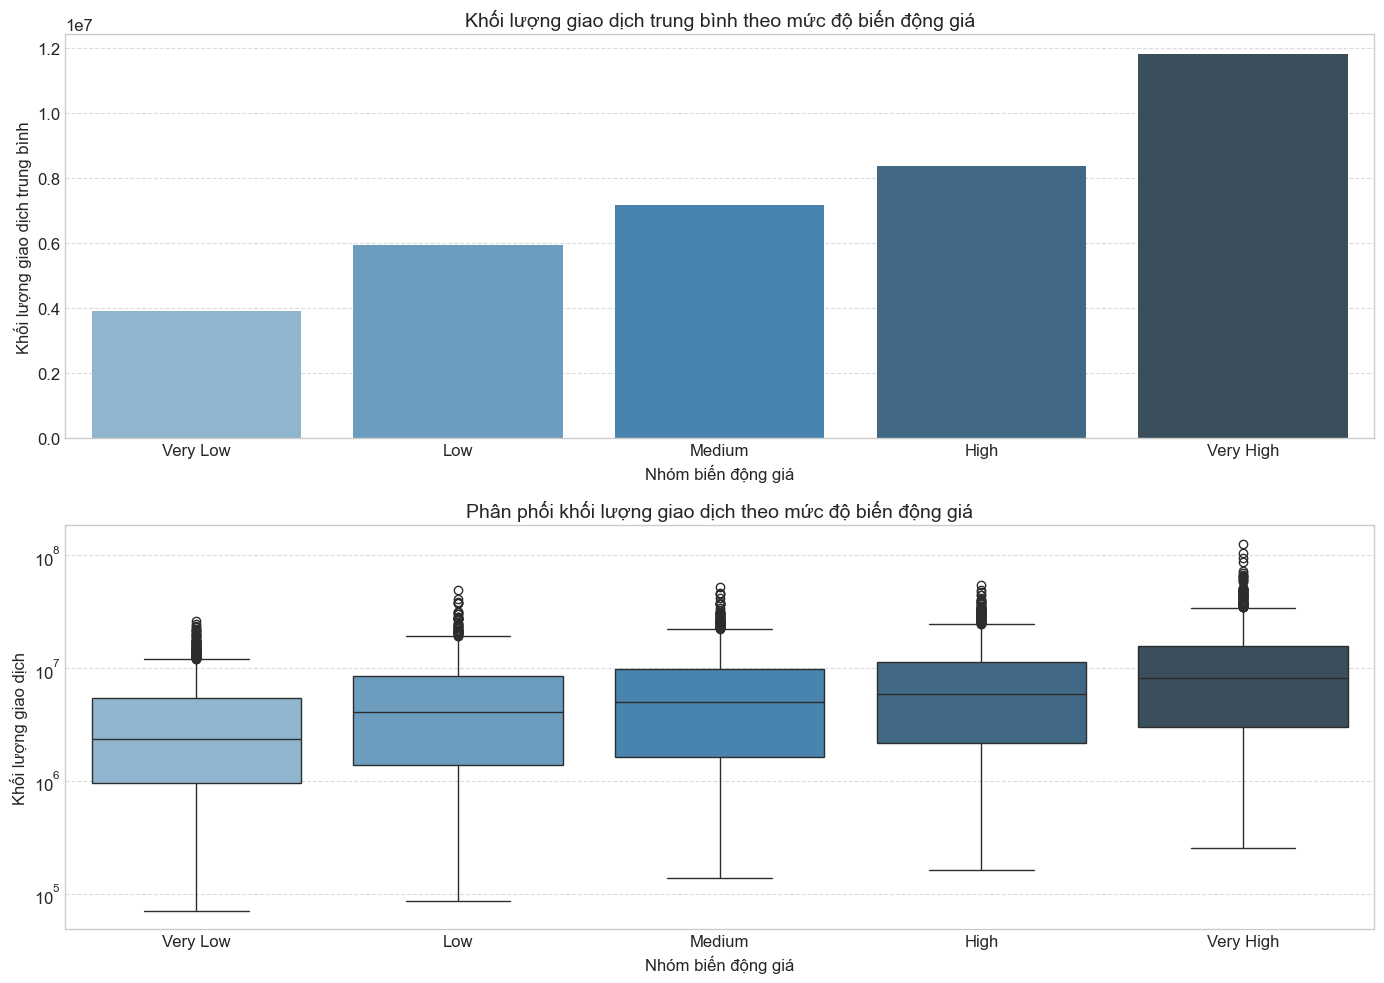

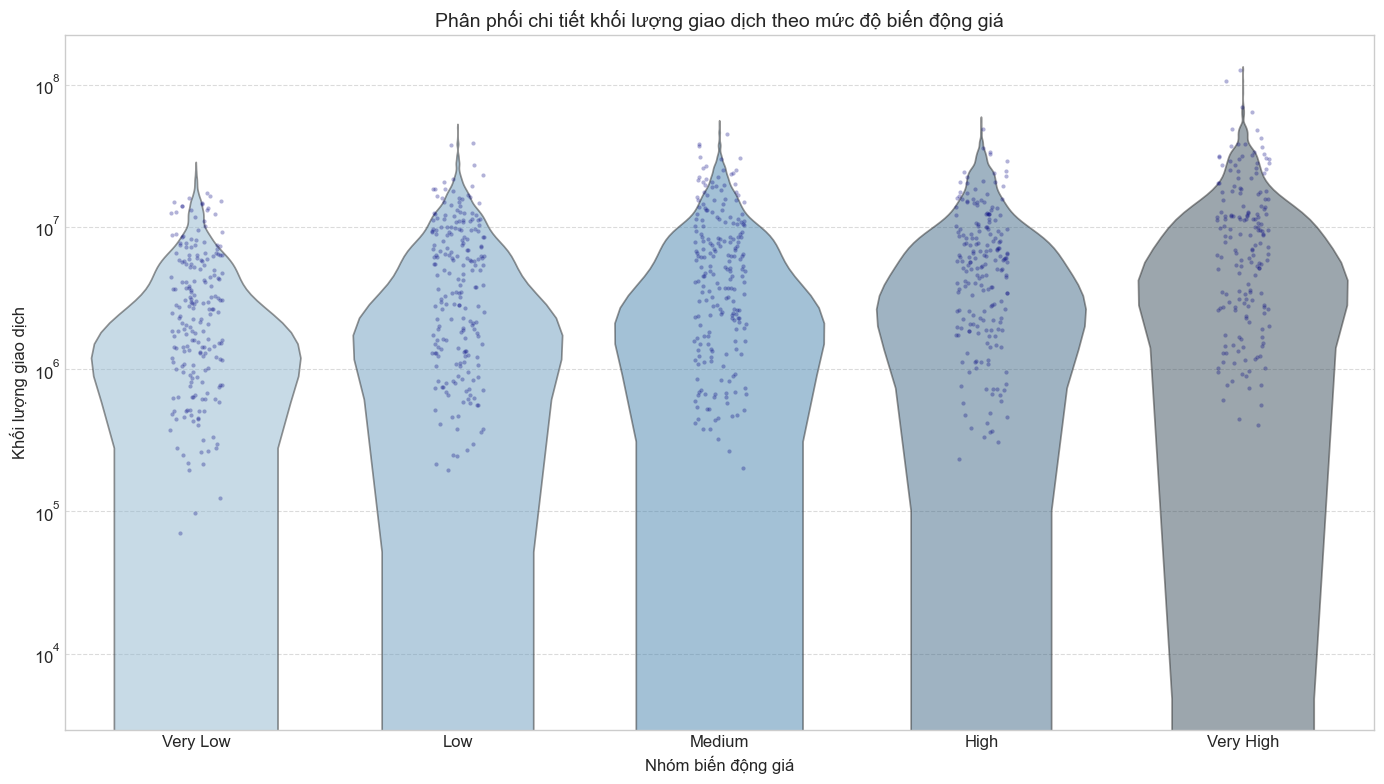

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Tính biến động giá
volatility_df = (df_high.iloc[:, 1:] - df_low.iloc[:, 1:]) / df_low.iloc[:, 1:] * 100
volatility_df['time'] = df_high['time']

# Chuẩn bị dữ liệu cho phân tích
distribution_data = pd.DataFrame()

for symbol in df_volume.columns[1:]:
    # Tạo DataFrame cho cổ phiếu này
    symbol_data = pd.DataFrame({
        'time': df_volume['time'],
        'symbol': symbol,
        'volume': df_volume[symbol],
        'volatility': volatility_df[symbol]
    }).dropna()
    
    distribution_data = pd.concat([distribution_data, symbol_data])

# Loại bỏ các outlier để biểu đồ rõ ràng hơn
q_low = distribution_data['volatility'].quantile(0.01)
q_high = distribution_data['volatility'].quantile(0.99)
filtered_data = distribution_data[(distribution_data['volatility'] >= q_low) & 
                                (distribution_data['volatility'] <= q_high)]

# Phân phối khối lượng theo phân vị biến động
filtered_data['volatility_quantile'] = pd.qcut(filtered_data['volatility'], 5, labels=False)
filtered_data['volatility_group'] = pd.qcut(filtered_data['volatility'], 5, 
                                          labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

# Tính khối lượng trung bình cho mỗi nhóm biến động
volume_by_volatility = filtered_data.groupby('volatility_group')['volume'].mean().reset_index()

# Vẽ biểu đồ
plt.figure(figsize=(14, 10))

# Biểu đồ 1: Khối lượng trung bình theo nhóm biến động
plt.subplot(2, 1, 1)
sns.barplot(data=volume_by_volatility, x='volatility_group', y='volume', palette='Blues_d')
plt.title('Khối lượng giao dịch trung bình theo mức độ biến động giá', fontsize=14)
plt.xlabel('Nhóm biến động giá')
plt.ylabel('Khối lượng giao dịch trung bình')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Biểu đồ 2: Box plot để so sánh phân phối
plt.subplot(2, 1, 2)
sns.boxplot(data=filtered_data, x='volatility_group', y='volume', palette='Blues_d')
plt.title('Phân phối khối lượng giao dịch theo mức độ biến động giá', fontsize=14)
plt.xlabel('Nhóm biến động giá')
plt.ylabel('Khối lượng giao dịch')
plt.yscale('log')  # Sử dụng log scale để dễ quan sát
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

# Phân tích thêm: Vẽ violin plot kết hợp scatter
plt.figure(figsize=(14, 8))
sns.violinplot(data=filtered_data, x='volatility_group', y='volume', palette='Blues_d', inner=None, alpha=0.5)
sns.stripplot(data=filtered_data.sample(1000), x='volatility_group', y='volume', color='navy', alpha=0.3, size=3)
plt.title('Phân phối chi tiết khối lượng giao dịch theo mức độ biến động giá', fontsize=14)
plt.xlabel('Nhóm biến động giá')
plt.ylabel('Khối lượng giao dịch')
plt.yscale('log')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()